In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1.  Libraries and settings

In [4]:

import math

import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


In [5]:
lookback_size = 40 # the length of the min/units the model looks back

## 2. Analyze data

In [6]:
NVDA_data = pd.read_csv("dataset/NVDA.csv").c

In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    data = data.reshape([*data.shape, 1])
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(NVDA_data, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (538957, 19, 1)
y_train.shape =  (538957, 1)
x_test.shape =  (134739, 19, 1)
y_test.shape =  (134739, 1)


In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#train_X = train_X.view([-1, x_train.shape[0], 1])
#test_X = test_X.view([-1, x_test.shape[0], 1])
#train_Y = train_Y.view([y_train.shape[0], 1])

In [9]:
y_train.size(),x_train.size()

(torch.Size([538957, 1]), torch.Size([538957, 19, 1]))

In [15]:
n_steps = look_back-1
batch_size = 1606
#n_iters = 3000
num_epochs = 100000 #n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 3. Build the structure of model

In [12]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/Users/teera/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# Train model
#####################

hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    print(f"Teera is in epoch  {t}")
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
    
    if (t + 1) % 1000 == 0:
        torch.save(model, f"checkpoint{t}.pth")

Teera is in epoch  0
Teera is in epoch  1
Teera is in epoch  2
Teera is in epoch  3
Teera is in epoch  4
Teera is in epoch  5
Teera is in epoch  6
Teera is in epoch  7
Teera is in epoch  8
Teera is in epoch  9
Teera is in epoch  10
Epoch  10 MSE:  21226.0390625
Teera is in epoch  11
Teera is in epoch  12
Teera is in epoch  13
Teera is in epoch  14
Teera is in epoch  15
Teera is in epoch  16
Teera is in epoch  17
Teera is in epoch  18
Teera is in epoch  19
Teera is in epoch  20
Epoch  20 MSE:  20431.568359375
Teera is in epoch  21
Teera is in epoch  22
Teera is in epoch  23
Teera is in epoch  24
Teera is in epoch  25
Teera is in epoch  26
Teera is in epoch  27
Teera is in epoch  28
Teera is in epoch  29
Teera is in epoch  30
Epoch  30 MSE:  19668.4375
Teera is in epoch  31
Teera is in epoch  32
Teera is in epoch  33
Teera is in epoch  34
Teera is in epoch  35
Teera is in epoch  36
Teera is in epoch  37
Teera is in epoch  38
Teera is in epoch  39
Teera is in epoch  40
Epoch  40 MSE:  189

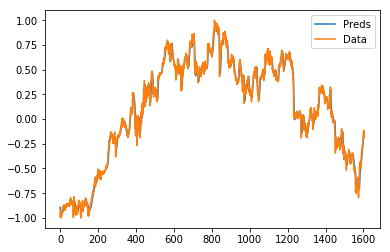

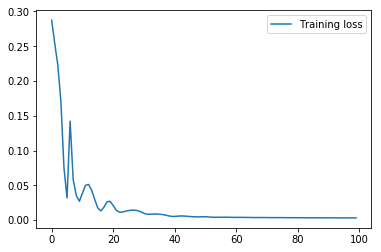

In [14]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend() 


plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [15]:
np.shape(y_train_pred)

torch.Size([1606, 1])

In [16]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.40 RMSE
Test Score: 1.85 RMSE


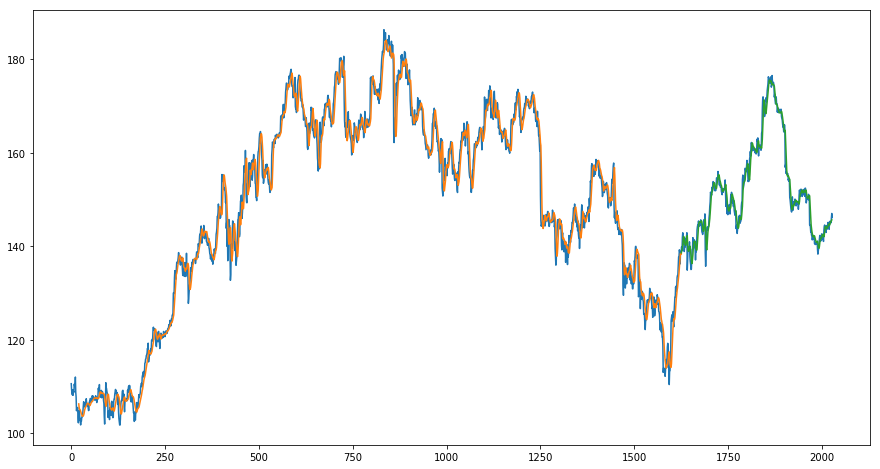

In [17]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_ibm)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()